# EXPLORATION OF SHELTER ANIMAL OUTCOMES
### aka Saving Kittens with Data

By Elizabeth Bradford

As someone who has volunteered in an animal shelter, I know first hand that rational thinking can go out of the window when dealing with the immediate needs of an animal in distress. I was drawn to this dataset because I hope to uncover some bigger picture insights that could be shared with shelter workers to allow them to ensure the best possible outcomes for animals in their care.

For example, perhaps we can derive a list of features that appear to make an animal less likely to be adopted, to be shared in the hope that then shelter workers can then identify ways to not let animals with those features slip through the cracks in future, or to take measures to remove those detrimental features from animals (e.g. have them neutered or spayed).

This dataset was found on Kaggle, and is available to view at: https://www.kaggle.com/c/shelter-animal-outcomes

In [285]:
import numpy as np
import pandas as pd

#Read in CSV file to Pandas

animals = pd.read_csv("train.csv")

#Print the first few entries and some descriptive information about each column

print animals.head()
print animals.describe()

  AnimalID     Name             DateTime      OutcomeType OutcomeSubtype  \
0  A671945  Hambone  2014-02-12 18:22:00  Return_to_owner            NaN   
1  A656520    Emily  2013-10-13 12:44:00       Euthanasia      Suffering   
2  A686464   Pearce  2015-01-31 12:28:00         Adoption         Foster   
3  A683430      NaN  2014-07-11 19:09:00         Transfer        Partner   
4  A667013      NaN  2013-11-15 12:52:00         Transfer        Partner   

  AnimalType SexuponOutcome AgeuponOutcome                        Breed  \
0        Dog  Neutered Male         1 year        Shetland Sheepdog Mix   
1        Cat  Spayed Female         1 year       Domestic Shorthair Mix   
2        Dog  Neutered Male        2 years                 Pit Bull Mix   
3        Cat    Intact Male        3 weeks       Domestic Shorthair Mix   
4        Dog  Neutered Male        2 years  Lhasa Apso/Miniature Poodle   

         Color  
0  Brown/White  
1  Cream Tabby  
2   Blue/White  
3   Blue Cream  
4      

Looking at the data from this high level, we see immediately that we have some discrepancies in count per column - indicating that some data points are missing.  I will likely choose to deal with these missing values on a case by case basis, as I use the features in question, rather than by standardizing the dataset at this early point.

We see that certain features, such as breed and color, contain a very large number of unique values. These categories will likely need to be consolidated in order to extract useful results. That said, AnimalType and SexuponOutcome appear more immediately useful.

In [2]:
#Take a look at unique values within OutcomeType - which is the label we're interested in investigating
#Also our features with fewer unique values - AnimalType and SexuponOutcome

print "Outcomes:"
print animals["OutcomeType"].unique()
print "Animal Types:"
print animals["AnimalType"].unique()
print "Sex Types:"
print animals["SexuponOutcome"].unique()


Outcomes:
['Return_to_owner' 'Euthanasia' 'Adoption' 'Transfer' 'Died']
Animal Types:
['Dog' 'Cat']
Sex Types:
['Neutered Male' 'Spayed Female' 'Intact Male' 'Intact Female' 'Unknown'
 nan]


## CATS VS DOGS - OUTCOME TYPE

For my first exploration of patterns, I will create a visualization to assess numbers of each animal type (i.e. cat or dog) across outcomes. Since we have just seen that there are no NaNs in either column, we do not need to do any pre-processing.

Populating the interactive namespace from numpy and matplotlib
AnimalType        Cat   Dog
OutcomeType                
Adoption         4272  6497
Died              147    50
Euthanasia        710   845
Return_to_owner   500  4286
Transfer         5505  3917


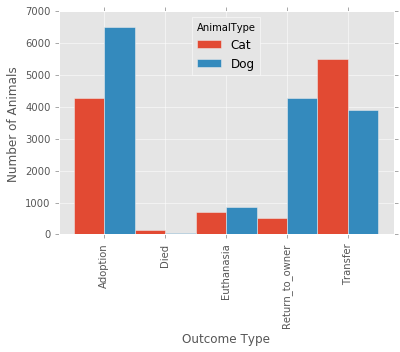

In [3]:
#Group by OutcomeType and AnimalType
animals_by_outcome_and_type = animals.groupby(["OutcomeType", "AnimalType"])

#Create a bar chart to visualize the data

%pylab inline
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

def outcome_bar_plot(groupby_object):
    count = groupby_object["OutcomeType"].count()
    #Unstack to show cat or dog, or any categories under consideration, in different colors
    unstacked_count = count.unstack() 
    print unstacked_count
    chart = unstacked_count.plot(kind="bar", width=1.0)
    chart.set_ylabel("Number of Animals")
    chart.set_xlabel("Outcome Type")    
    
outcome_bar_plot(animals_by_outcome_and_type)


It's not easy to discern any obvious patterns from this visualization.  Certain outcomes (such as adoption, return to owner) were more prevalent with dogs than cats. And certain outcomes were more prevalent with cats (such as transfer).  

But what I have failed to account for here - and will now correct - is outcome per animal type as a proportion of total number of animals of that type.  For example, if there were twice as many dogs as cats overall, it would not be very meaningful to discern that an outcome was more frequent for dogs than cats. 

## CATS VS DOGS - OUTCOME TYPE - IN PROPORTIONATE TERMS

                      Cat       Dog
OutcomeType                        
Adoption         0.383690  0.416608
Died             0.013203  0.003206
Euthanasia       0.063769  0.054184
Return_to_owner  0.044907  0.274832
Transfer         0.494431  0.251170


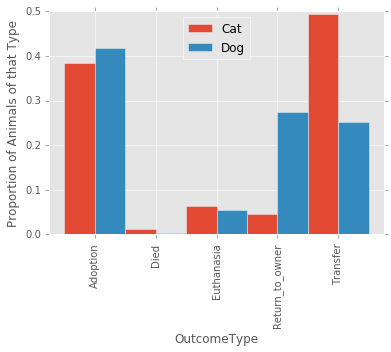

In [4]:
"""
This function outputs proportions in a groupby object
E.g. If grouped by outcome and  color - for each color, we'll see 
proportion of all animals of that color that experience each outcome
"""
def outcome_as_proportion(groupby_object):
    count = groupby_object["OutcomeType"].count()
    unstacked_count = count.unstack()
    list_of_columns = unstacked_count.columns.values.tolist()
    list_of_sums = []
    #Iterate through the unstacked_count dataframe, sum each column of the dataframe, and add to a list
    for column_name in list_of_columns:
        new_sum = unstacked_count[column_name].sum()
        list_of_sums.append(new_sum)
    #Create new dataframe that will contain the proportions
    unstacked_proportion = pd.DataFrame()
    #Iterate through the columns of the unstacked_count dataframe
    i = 0
    while i < len(list_of_columns):
        #Create a new column where each value in original column is divided by the sum of all values in that column 
        new_column = unstacked_count[list_of_columns[i]] / float(list_of_sums[i])
        #Add that new column to proportions dataframe, named according to its name in unstacked dataframe
        unstacked_proportion[list_of_columns[i]] = new_column
        i += 1
    print unstacked_proportion
    return unstacked_proportion

"""
This function performs a group by, feeds the group by into the proportion
function defined above, plots a chart of the returned proportions, then returns that chart
- in case it requires further tweaking, such as appropriately naming the x-axis.
"""
def group_and_plot(first_group, second_group, dataframe):
    grouped_dataframe = dataframe.groupby([first_group, second_group])
    unstacked_proportion = outcome_as_proportion(grouped_dataframe)
    chart = unstacked_proportion.plot(kind="bar", width=1.0)
    chart.set_ylabel("Proportion of Animals of that Type")
    return chart

   
chart = group_and_plot("OutcomeType", "AnimalType", animals)
chart.set_xlabel("OutcomeType")

Now we have a more digestible representation of animal outcome by type. For example, we can see that slightly more than 40% of dogs were adopted versus slightly less than 40% of cats.  And whereas we might have incorrectly deduced from our previous graph that dogs are more likely to be euthanized, here we see that in fact, proportionally speaking, cats are slightly more likely to be euthanized than dogs. 

## CATS VS DOGS - OUTCOME TYPE - STATISTICAL ANALYSIS

To dig further into our data, I will perform a chi squared test of association.

The null hypothesis is that there is no overall difference between cats and dogs with respect to outcome type. 

In other words, animal type is not associated with outcome type. 

In [5]:
import scipy.stats

"""
Define function that takes in two columns from our dataframe, assembles them into a groupby object, finds the
unstacked count, and feeds those values as an array into a calculation of chi squared contingency.

The function returns the test statistic, and the probability value of observing that test statistic by chance.
"""


def perform_chi_squared(first_group, second_group, dataframe):
    groupby_object = dataframe.groupby([first_group, second_group])
    count = groupby_object["OutcomeType"].count()
    unstacked_count = count.unstack() 
    f_observed = []
    for column in unstacked_count:
        observed_per_category = unstacked_count[str(column)].tolist()
        f_observed.append(observed_per_category)
    statistic = scipy.stats.chi2_contingency(f_observed)
    print "Test Statistic:", statistic[0]
    print "p-value:", statistic[1]
    
    
perform_chi_squared("OutcomeType", "AnimalType", animals)
        

Test Statistic: 3124.27608966
p-value: 0.0


Looking at our p-value, we see that is extremely unlikely that our observed results were a matter of chance alone, leading us to conclude that <b>there is an association between animal type and outcome type<b>.

## SEX - OUTCOME TYPE

Let's move on to examining SexuponOutcome against Outcome Type to assess if there might be an association there.

In [122]:
print animals["SexuponOutcome"].unique()

['Neutered Male' 'Spayed Female' 'Intact Male' 'Intact Female' 'Unknown'
 nan]


There are both unknowns and NaNs in the Sex column, so we will take steps to remove these.

In [123]:
#First create a new column that drops the Unknown sex entries from the dataframe
animals["With Sex"] = animals["SexuponOutcome"][(animals["SexuponOutcome"] != "Unknown")]

#Create a new dataframe taking the rows where that new column is not null.
animals_with_sex = animals[animals["With Sex"].notnull()]

print animals_with_sex.head(10)  
print animals_with_sex.count()
                                        

   AnimalID     Name             DateTime      OutcomeType OutcomeSubtype  \
0   A671945  Hambone  2014-02-12 18:22:00  Return_to_owner            NaN   
1   A656520    Emily  2013-10-13 12:44:00       Euthanasia      Suffering   
2   A686464   Pearce  2015-01-31 12:28:00         Adoption         Foster   
3   A683430      NaN  2014-07-11 19:09:00         Transfer        Partner   
4   A667013      NaN  2013-11-15 12:52:00         Transfer        Partner   
5   A677334     Elsa  2014-04-25 13:04:00         Transfer        Partner   
6   A699218    Jimmy  2015-03-28 13:11:00         Transfer        Partner   
8   A671784     Lucy  2014-02-04 17:17:00         Adoption            NaN   
9   A677747      NaN  2014-05-03 07:48:00         Adoption        Offsite   
11  A666320      NaN  2013-11-04 14:48:00         Adoption            NaN   

   AnimalType SexuponOutcome AgeuponOutcome  \
0         Dog  Neutered Male         1 year   
1         Cat  Spayed Female         1 year   
2         D

                 Intact Female  Intact Male  Neutered Male  Spayed Female
OutcomeType                                                              
Adoption              0.057818     0.044823       0.534001       0.587982
Died                  0.015950     0.022411       0.001943       0.002041
Euthanasia            0.114212     0.135319       0.035177       0.026304
Return_to_owner       0.085731     0.135319       0.229778       0.198186
Transfer              0.726289     0.662128       0.199100       0.185488


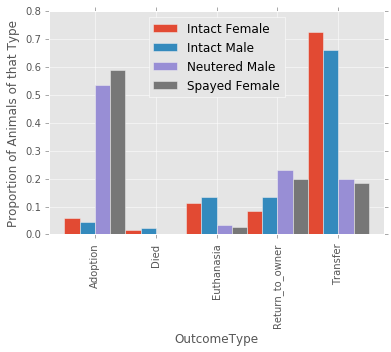

In [28]:
#Plot proportion of animals of each sex type that experienced each outcome type

chart = group_and_plot("OutcomeType", "SexuponOutcome", animals_with_sex)
chart.set_xlabel("OutcomeType")

What is striking about this visualization is the dominance of "fixed" animals (those that have been neutered or spayed) in the adoption category. Between 50 and 60% of neutered males and spayed females were adopted, as opposed to less than 10% of intact males and females.

Conversely, intact animals dominate in the transfer category, being transfered in more than 65% of cases. We could conjecture that the animals are being transferred in order to be spayed or neutered, but that fact is not in our data.

The difference in euthanasia rates between fixed and intact is also apparent, though not as pronounced.

Let's perform a chi squared test to see if there is statistical support for the observation that different sexes are related to difference outcomes

In [29]:
perform_chi_squared("OutcomeType", "SexuponOutcome", animals_with_sex)

Test Statistic: 8478.36199888
p-value: 0.0


As with Animal Type, we see a very high test statistic, and a low p-value, indicating that the observed results are unlikely to have occured by chance, and thus we can conclude that there is a <b>significant association between Sex and Outcome Type</b>.

## Animal Color
There are 366 unique colors in our dataset, and so this feature won't yield readily to analysis without consolidation.


## The Black Cat Effect
As a way to dip our toe into the question of color, let's see if black cats - thought by many to be unlucky - are any less likely to survive than any other animal. Since we have seen that there is a relationship between animal type and outcome type, we will just compare black cats (and only completely black cats) to other cats.

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Non-black cats: 9693
Black cats: 1441
                    Black  Not Black
OutcomeType                         
Adoption         0.356697   0.387702
Died             0.013185   0.013205
Euthanasia       0.063845   0.063757
Return_to_owner  0.041638   0.045394
Transfer         0.524636   0.489941


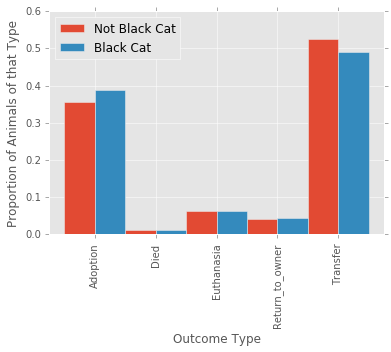

In [129]:
#Create dataframe that contains only the cats
just_cats = animals[animals["AnimalType"] == "Cat"]

#Create a column that lists "Black" where black cat, "Not Black" otherwise
just_cats["Black Cats"] = just_cats["Color"][just_cats["Color"] == "Black"]
just_cats["Black Cats"] = just_cats["Black Cats"].replace(nan, "Not Black")

#Print number of black cats and non-black cats
print "Non-black cats:", just_cats["Black Cats"].value_counts()[0]
print "Black cats:", just_cats["Black Cats"].value_counts()[1]

#Group by Surived and Black Cats and chart
chart = group_and_plot("OutcomeType", "Black Cats", just_cats)
#Modifications to make x-axis and legend more easily readable
chart.set_xlabel("Outcome Type")
L=chart.legend(loc=2)
L.get_texts()[0].set_text("Not Black Cat")
L.get_texts()[1].set_text("Black Cat")



Black cats seem roughly on par with non-black cats across outcome types.  Let's see if this observation is supported statistically with a chi-squared test of association.

In [130]:
perform_chi_squared("OutcomeType", "Black Cats", just_cats)

Test Statistic: 6.59158588253
p-value: 0.159110431


The p value is fairly high, indicating a significant probability that the observed difference in black cats and non-black cats vis-a-vis outcome type can be attributed to chance alone. Thus we <b>cannot conclude</b> that there is an association between being a black cat and outcome type.

A win for science over superstition!


## Date of Arrival - Outcome Type

I want to investigate whether the date the animal arrived at the shelter, as given by the DateTime column, bears any relationship to the likelihood of survival. Possible phenomena we might observe:

*A bump in adoption in the lead up to Christmas as people feel more charitable / look for gifts.

*A drop in adoption during "kitten/puppy season" (late spring-summer) where newborn kittens flood into shelters.

*Or possibly a bump in adoption during kitten season, due to adopters particularly looking for young animals .

To consolidate the number of unique date entries, I will consider just the year and month of animal arrival, and remove the time and day information.  

In [70]:
#To remove time from DateTime entry, create slicing function
#Then apply function to DateTime column to yield new column with just date as year and month
def entry_slicer(entry):
    entry = entry[0:7]
    return entry

animals["Just Date"] = animals["DateTime"].apply(entry_slicer)

print animals["Just Date"].head()
print animals["Just Date"].count()

0    2014-02
1    2013-10
2    2015-01
3    2014-07
4    2013-11
Name: Just Date, dtype: object
26729


                  2013-10   2013-11   2013-12   2014-01   2014-02   2014-03  \
OutcomeType                                                                   
Adoption         0.368583  0.425903  0.461622  0.416778  0.400922  0.358942   
Died             0.012320  0.003736  0.001081  0.005326  0.004608  0.006297   
Euthanasia       0.074949  0.061021  0.065946  0.061252  0.066052  0.070529   
Return_to_owner  0.152977  0.179328  0.152432  0.202397  0.213518  0.207809   
Transfer         0.391170  0.330012  0.318919  0.314248  0.314900  0.356423   

                  2014-04   2014-05   2014-06   2014-07    ...      2015-05  \
OutcomeType                                                ...                
Adoption         0.317274  0.318182  0.356941  0.442661    ...     0.335366   
Died             0.004700  0.008457  0.008499  0.010703    ...     0.008711   
Euthanasia       0.056404  0.053911  0.067989  0.061927    ...     0.068815   
Return_to_owner  0.220917  0.163848  0.149197  0.11

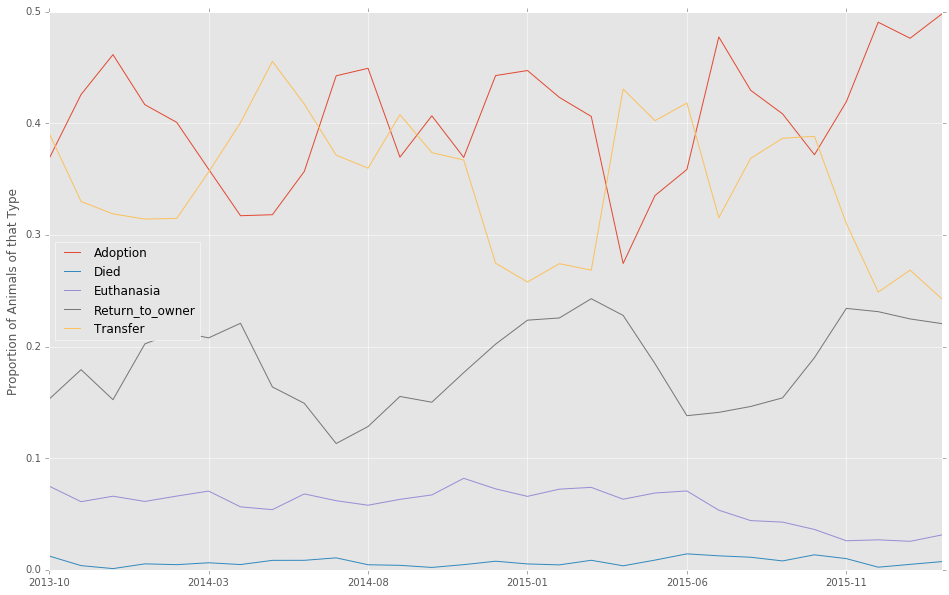

In [67]:
#I need to alter the plot parameters somewhat to accommodate the many more categories.
def group_and_plot_for_date(first_group, second_group, dataframe):
    grouped_dataframe = dataframe.groupby([first_group, second_group])
    unstacked_proportion = outcome_as_proportion(grouped_dataframe)
    i = 0
    while i < len(unstacked_proportion):
        chart = unstacked_proportion.iloc[i].plot(figsize=(16,10)) 
        i += 1
    chart.set_ylabel("Proportion of Animals of that Type")
    return chart

chart = group_and_plot_for_date("OutcomeType", "Just Date", animals)
L=chart.legend(loc=6)


There a lot of information to process on this graph. It's hard to identify trends.  The better approach may be to reduce down the date information  even further to just include the month, as the trends we hypothesized in advance are ones that would re-occur on an annual basis.

In [313]:
def month_slicer(entry):
    entry = int(entry[5:7])
    return entry

animals["Month"] = animals["DateTime"].apply(month_slicer)

print animals["Month"].head()
print animals["Month"].count()

0     2
1    10
2     1
3     7
4    11
Name: Month, dtype: int64
26729


In [314]:
print animals["Month"].value_counts()

10    2881
12    2691
11    2668
7     2506
1     2334
6     2319
8     2172
5     2094
9     2004
2     1873
4     1689
3     1498
Name: Month, dtype: int64


                       1         2         3         4         5         6   \
OutcomeType                                                                   
Adoption         0.447729  0.437266  0.381175  0.296033  0.327603  0.357913   
Died             0.005141  0.005339  0.007343  0.004144  0.008596  0.011643   
Euthanasia       0.050129  0.058195  0.072096  0.059799  0.062082  0.069426   
Return_to_owner  0.217224  0.219968  0.224299  0.224393  0.175263  0.143165   
Transfer         0.279777  0.279231  0.315087  0.415631  0.426457  0.417853   

                       7         8         9         10        11        12  
OutcomeType                                                                  
Adoption         0.459298  0.439687  0.389222  0.382159  0.405172  0.464511  
Died             0.011572  0.007827  0.005988  0.009372  0.006372  0.003716  
Euthanasia       0.057861  0.051105  0.052894  0.059354  0.054723  0.055741  
Return_to_owner  0.126496  0.137201  0.154691  0.164526 

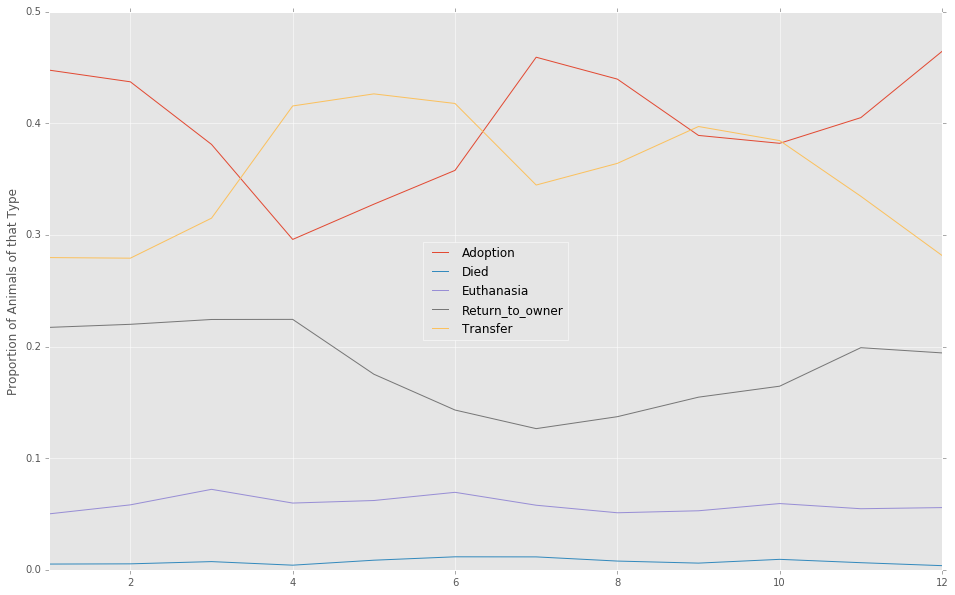

In [315]:
#As above, plot each outcome type as a separate line on the chart
chart = group_and_plot_for_date("OutcomeType", "Month", animals)
L=chart.legend(loc=10)


Here we can see that death and euthanasia occur at pretty steady rates across the calendar year.  Adoption does seem to have two upward trends - roughly around kitten/puppy season from April to July, and then again in the lead up to Christmas.  Transfers drop at the end of the year, and returns to owner slump in the summertime. 

To feel more secure in these trends, we would want many more years of data, but let's see what chi-squared is telling us now about an association between month and outcome type.

In [117]:
animals["Month"] = animals["Month"].replace(1, "January")
animals["Month"] = animals["Month"].replace(2, "February")
animals["Month"] = animals["Month"].replace(3, "March")
animals["Month"] = animals["Month"].replace(4, "April")
animals["Month"] = animals["Month"].replace(5, "May")
animals["Month"] = animals["Month"].replace(6, "June")
animals["Month"] = animals["Month"].replace(7, "July")
animals["Month"] = animals["Month"].replace(8, "August")
animals["Month"] = animals["Month"].replace(9, "September")
animals["Month"] = animals["Month"].replace(10, "October")
animals["Month"] = animals["Month"].replace(11, "November")
animals["Month"] = animals["Month"].replace(12, "December")

print animals["Month"].head(20)
print animals["Month"].value_counts()

0     February
1      October
2      January
3         July
4     November
5        April
6        March
7        April
8     February
9          May
10    December
11    November
12    February
13        June
14    November
15        July
16         May
17        June
18         May
19        July
Name: Month, dtype: object
October      2881
December     2691
November     2668
July         2506
January      2334
June         2319
August       2172
May          2094
September    2004
February     1873
April        1689
March        1498
Name: Month, dtype: int64


In [118]:
perform_chi_squared("OutcomeType", "Month", animals)

Test Statistic: 586.076638817
p-value: 7.31670883061e-96


Here we have a very small p-value, suggesting <b>there is a significant association between month and outcome type</b>.

## Animal Age - Outcome Type

Age can correctly be considered a continuous variable rather than a categorical one, and thus we should convert the text ages we've been given into integer values of days.

In [316]:
#First create new dataframe where rows missing an Age have been removed
animals_with_age = animals[animals["AgeuponOutcome"].notnull()]

print animals_with_age["AgeuponOutcome"].count()
print animals_with_age["AgeuponOutcome"].unique()


26711
['1 year' '2 years' '3 weeks' '1 month' '5 months' '4 years' '3 months'
 '2 weeks' '2 months' '10 months' '6 months' '5 years' '7 years' '3 years'
 '4 months' '12 years' '9 years' '6 years' '1 weeks' '11 years' '4 weeks'
 '7 months' '8 years' '11 months' '4 days' '9 months' '8 months' '15 years'
 '10 years' '1 week' '0 years' '14 years' '3 days' '6 days' '5 days'
 '5 weeks' '2 days' '16 years' '1 day' '13 years' '17 years' '18 years'
 '19 years' '20 years']


In [317]:
#Define function to convert age column to number of days (rounded to nearest day)
def age_converter(age_column):
    times_list = ["year", "month", "week", "day"]
    list_of_unconverted_ages = age_column.values.tolist()
    list_of_converted_ages = []
    for item in list_of_unconverted_ages:
        i = 0
        while i < len(times_list):
            if times_list[i] in item:
        #for time in times_list:
            #if time in item:
                current_time = times_list[i]
                i += 1
                space_location = item.index(" ")
                cut_item = item[:space_location]
                if current_time == "year":
                    list_of_converted_ages.append(int(cut_item)*365)
                if current_time == "month":
                    list_of_converted_ages.append(int(float(cut_item)*(365.0/12)))
                if current_time == "week":
                    list_of_converted_ages.append(int(cut_item)*7)
                if current_time == "day":
                    list_of_converted_ages.append(int(cut_item))
            else:
                i += 1
                #else:
                #    new_column.append(0.0)
    return pd.Series(list_of_converted_ages)

#Convert age column
animals_with_age["Age Converted"] = age_converter(animals_with_age["AgeuponOutcome"])

print animals_with_age["Age Converted"].head()
print animals_with_age["Age Converted"].count()

0    365.0
1    365.0
2    730.0
3     21.0
4    730.0
Name: Age Converted, dtype: float64
26693


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [291]:
#The conversion process is creating 11 nans. Let's remove them
animals_with_age = animals_with_age[animals_with_age["Age Converted"].notnull()]

In [292]:
print animals_with_age["Age Converted"].unique()

[  3.65000000e+02   7.30000000e+02   2.10000000e+01   3.00000000e+01
   1.52000000e+02   1.46000000e+03   9.10000000e+01   1.40000000e+01
   6.00000000e+01   3.04000000e+02   1.82000000e+02   1.82500000e+03
   2.55500000e+03   1.09500000e+03   1.21000000e+02   4.38000000e+03
   3.28500000e+03   2.19000000e+03   7.00000000e+00   4.01500000e+03
   2.80000000e+01   2.12000000e+02   2.92000000e+03   3.34000000e+02
   4.00000000e+00   2.73000000e+02   2.43000000e+02   5.47500000e+03
   3.65000000e+03   0.00000000e+00   5.11000000e+03   3.00000000e+00
   6.00000000e+00   5.00000000e+00   3.50000000e+01   2.00000000e+00
   5.84000000e+03   1.00000000e+00   4.74500000e+03   6.20500000e+03
   6.57000000e+03   6.93500000e+03   7.30000000e+03]


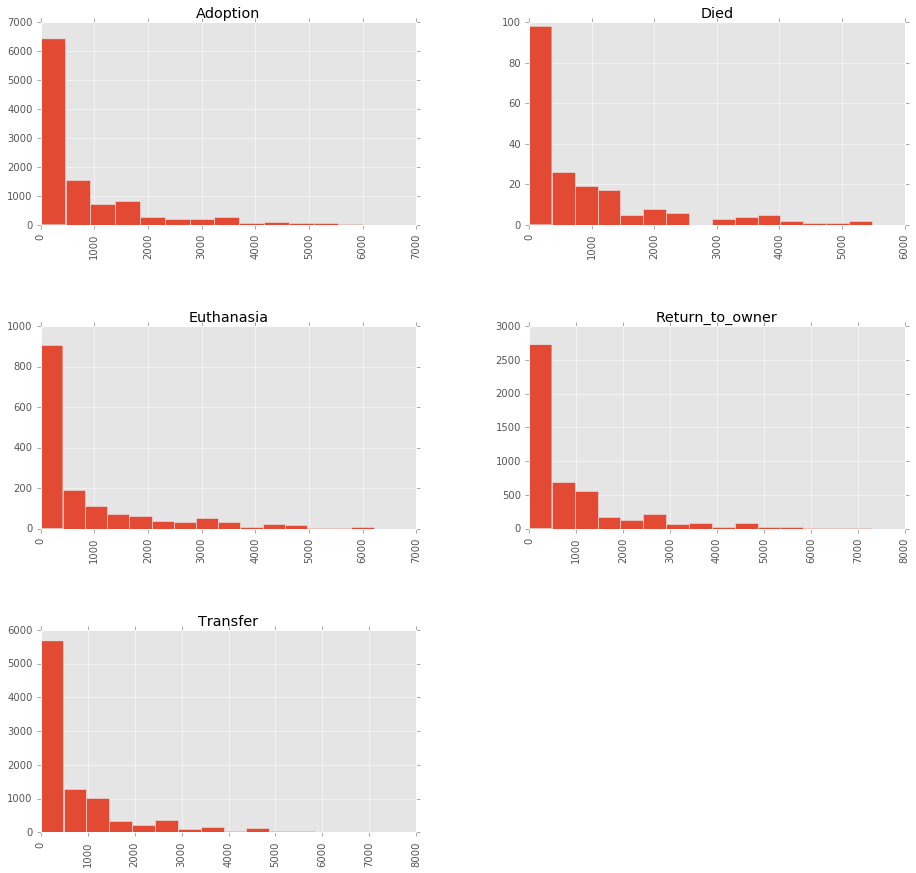

In [293]:
#Plot separate charts to show distribution of ages for each of the five outcome types
chart = animals_with_age["Age Converted"].hist(by=animals_with_age["OutcomeType"], figsize=(15,15), bins=15)


So we see that younger animals predominate across Outcome Types. It's hard to discern visually if there are any significant difference in the age distributions for each outcome. 

I will now create lists of the age of every individual that experienced each outcome, to be used as inputs to two-sample t-tests for independent samples.

In [295]:
#Group animals by outcome and age, find number of animals of each age that experienced each outcome
animals_by_outcome_and_age = animals_with_age.groupby(["Age Converted", "OutcomeType"])
count = animals_by_outcome_and_age["Age Converted"].count()
unstacked_count = count.unstack()
print unstacked_count

#Take each series of outcome counts and assemble into a numpy array with each outcome a separate column,
#and each row corresponding to a separate age. I will replace missing values with 0, i.e. no animals of
#that age experienced that outcome.
list_of_arrays = [np.array(unstacked_count["Adoption"].replace(nan,0))[:, None], 
                  np.array(unstacked_count["Died"].replace(nan,0))[:, None],
                  np.array(unstacked_count["Euthanasia"].replace(nan,0))[:, None],
                  np.array(unstacked_count["Return_to_owner"].replace(nan,0))[:, None],
                  np.array(unstacked_count["Transfer"].replace(nan,0))[:, None]]
    
counts_array = np.concatenate(list_of_arrays, axis=1)

#Create a list of all possible ages
ages_list = animals_with_age["Age Converted"].unique().tolist()
ages_list.sort() #Sort from smallest to largest
ages_array = np.array(ages_list)#Convert to array
print ages_array


OutcomeType    Adoption  Died  Euthanasia  Return_to_owner  Transfer
Age Converted                                                       
0.0                 5.0   1.0         3.0              3.0      10.0
1.0                20.0   1.0         5.0             18.0      22.0
2.0                40.0   1.0         7.0             11.0      40.0
3.0                38.0   1.0         4.0             20.0      45.0
4.0                20.0   1.0         1.0              7.0      21.0
5.0                10.0   1.0         1.0              6.0       6.0
6.0                18.0   1.0         4.0              6.0      21.0
7.0               117.0   5.0        10.0             55.0     129.0
14.0              180.0   3.0        26.0             93.0     226.0
21.0              255.0   4.0        42.0            108.0     250.0
28.0              108.0   3.0        32.0             65.0     126.0
30.0              488.0  13.0        73.0            192.0     514.0
35.0                3.0   1.0     

In [296]:
#Define function that will take a column from the counts array, and return a new array which list the age
#of every individual that experienced that outcome. For example, if 131 animals aged 7 days were adopted, 
#the adoption array returned will contain 131 instances of the number 7.
def create_sample_array(possible_days, counts_column):
    samples_list = []
    j = 0
    for days in possible_days:
        i = 0
        while i < counts_column[j]:
            samples_list.append(days)
            i += 1
        j += 1
    samples_array = np.array(samples_list)
    return samples_array

#Create array containing age of every animal adopted, and another of every animal euthanized.
adoption_sample = create_sample_array(ages_array, counts_array[:,0])
euthanasia_sample = create_sample_array(ages_array, counts_array[:,2])

adoption_mean_age = adoption_sample.mean()
print "Adoption Mean Age:", adoption_mean_age
euthanasia_mean_age = euthanasia_sample.mean()
print "Euthanasia Mean Age:", euthanasia_mean_age


Adoption Mean Age: 779.210482297
Euthanasia Mean Age: 869.270618557


Now we can see that there is a difference in means. But is it statistically significant?

In [254]:
t_test = scipy.stats.ttest_ind(adoption_samples, euthanasia_samples, axis=0, equal_var=False)
print "Test Statistic:", t_test[0]
print "p-value:", t_test[1]



 Test Statistic: -2.59120967515
p-value: 0.00963648191592


With this two tailed test, we see that the mean ages of adoption and euthanasia are significantly different at a confidence level of over 99%.

In fact, we see that adoption mean age was lower.  The difference between the means is about 90 days.

Perhaps there is also a significant difference in mean age for died vs euthanasia, if you suppose that animals dying of natural causes may be dying because they are older.

In [318]:
#Wrap process in a function, that prints the two means,  the t-statistic, and p-value.
def perform_t_test(outcome1, outcome2):
    outcome1_sample = create_sample_array(ages_array, outcome1)
    outcome2_sample = create_sample_array(ages_array, outcome2)
    outcome1_mean_age = outcome1_sample.mean()
    outcome2_mean_age = outcome2_sample.mean()
    print "Outcome 1 Mean Age:", outcome1_mean_age
    print "Outcome 2 Mean Age:", outcome2_mean_age
    t_test = scipy.stats.ttest_ind(outcome1_sample, outcome2_sample, axis=0, equal_var=False)
    print "Test Statistic:", t_test[0]
    print "p-value:", t_test[1]

Died = counts_array[:,1]
Euthanasia = counts_array[:,2]

perform_t_test(Died,Euthanasia)



Outcome 1 Mean Age: 782.126903553
Outcome 2 Mean Age: 869.270618557
Test Statistic: -1.01427565439
p-value: 0.311417391342


The high p value shows us there is not a significant difference between the mean age of euthanasia and the mean age of death, so it doesn't seem to be a matter of older animals being more likely to died.

What about adoption vs return to owner? For an animal to have an owner to return to, it implies that they have lived long enough to be adopted at some point - and thus might suggest returned animals are significantly older than adopted ones.

In [311]:
Adoption = counts_array[:,0]
Return = counts_array[:, 3]

perform_t_test(Adoption, Return)

Outcome 1 Mean Age: 779.210482297
Outcome 2 Mean Age: 846.102215719
Test Statistic: -3.48200408591
p-value: 0.000500130171168


And indeed we have a significant result here, at a confidence level of over 99%, that returned animals have a higher mean age than adopted ones. 

## Current Conclusions

At this stage, there are certain recommendations I would make to shelter animals workers to help them ensure the survival of as many animals as possible:

*Make sure that every animals is spayed or neutered.  Many shelters actually include the cost of spaying/neutering in the adoption fee, and I'd recommend this policy be adopted across the board.

*Focus attention on getting older animals adopted. We have seen that average adoption age is significantly less than the average euthanasia age, so it seems imperative that the shelter workers not miss the "window of adoptability" that younger animals seem to have.

*Take advantage in the boost of adoptions during kitten/puppy season and in the run up to Christmas by hosting special events or offering adoption fee discounts. 

